In [38]:
import numpy as np
import pandas as pd

In [39]:
path = "Sarcasm_Headlines_Dataset_v2.json"

In [40]:
df = pd.read_json(path, lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [41]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [42]:
del df['article_link']

In [43]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [44]:
import seaborn as sns

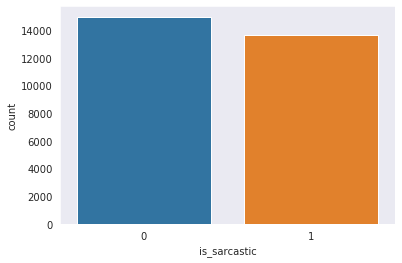

In [45]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [46]:
import nltk
from nltk.corpus import stopwords
import re,string,unicodedata

In [47]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**BASIC DATA CLEANING**

In [48]:
from bs4 import BeautifulSoup

In [49]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

**WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC (LABEL - 0)**

In [50]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [51]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))


<Figure size 1440x1440 with 0 Axes>

**WORDCLOUD FOR SARCASTIC TEXT (LABEL - 1)**

In [52]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))

<Figure size 1440x1440 with 0 Axes>

**Number of characters in texts**

In [53]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [54]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [55]:
len(w2v_model.wv.vocab)

38071

In [56]:
from keras.preprocessing import text, sequence

In [57]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [58]:
vocab_size = len(tokenizer.word_index) + 1

In [59]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [60]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


# TRAINING WORD2VEC MODEL

**Defining Neural Network
LSTM**

In [61]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [62]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))

model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                55488     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,006,849
Trainable params: 8,006,849
Non-trainable params: 0
_________________________________________________________________


In [64]:
from sklearn.model_selection import train_test_split

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [66]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/3
20033/20033 [==============================] - 16s 775us/step - loss: 0.5144 - acc: 0.7342 - val_loss: 0.4339 - val_acc: 0.8062
Epoch 2/3
20033/20033 [==============================] - 12s 616us/step - loss: 0.1562 - acc: 0.9418 - val_loss: 0.4846 - val_acc: 0.7949
Epoch 3/3
20033/20033 [==============================] - 13s 653us/step - loss: 0.0442 - acc: 0.9855 - val_loss: 0.6658 - val_acc: 0.7949


In [67]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

20033/20033 [==============================] - 9s 437us/step
Accuracy of the model on Training Data is -  99.69550371170044
8586/8586 [==============================] - 4s 426us/step
Accuracy of the model on Testing Data is -  79.48986887931824


# ANALYSIS AFTER TRAINING OF WORD2VEC MODEL 

In [68]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

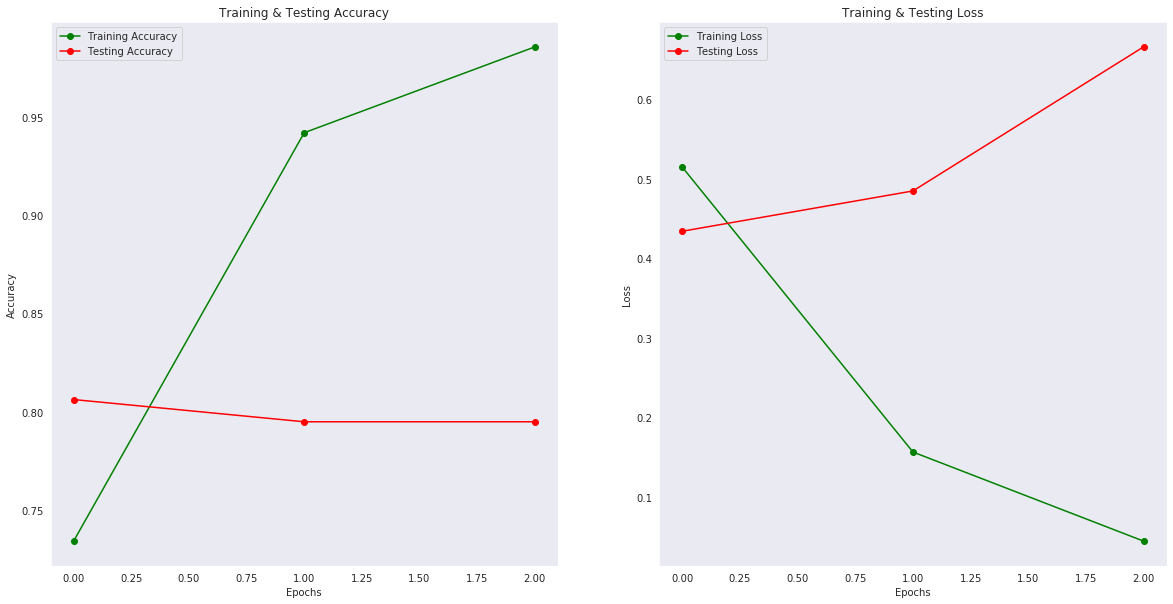

In [69]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**SEEMS LIKE THE MODEL IS OVERFITTING AND NOT PERFORMING WELL ON THE TEST DATA**

In [70]:
pred = model.predict_classes(x_test)
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [71]:
cm = confusion_matrix(y_test,pred)
cm

array([[3606,  954],
       [ 807, 3219]])

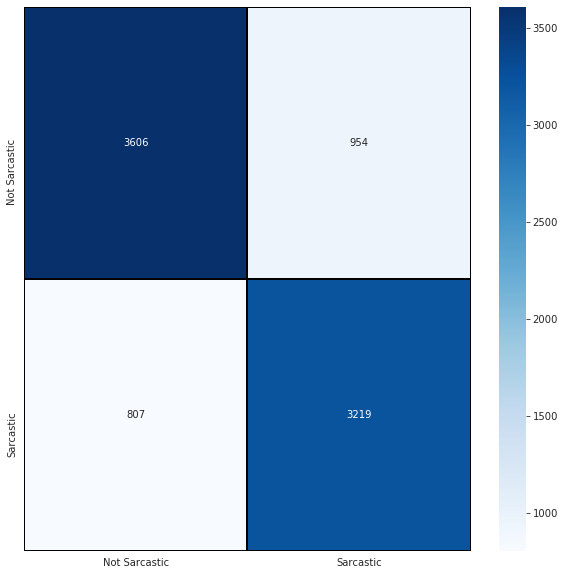

In [72]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])